# BIO-SELECT - Marigliano

In [1]:
from sklearn import neighbors, datasets
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline

## Load datasamples from MILE

In [3]:
from sklearn.cross_validation import train_test_split

from datasets.EGEOD22619Dataset import EGEOD22619Dataset
from datasets.MileDataset import MileDataset

# ds = MileDataset(full_dataset=True)
ds = EGEOD22619Dataset()

X = ds.get_X()
y = ds.get_y()
#print(X)
print(len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


16


## Classification using dumb KNN (all features)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=4, algorithm="auto")
classifier = classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)
print("score :", score)

score : 0.714285714286


## Classification using ExtraTree

score : 0.571428571429


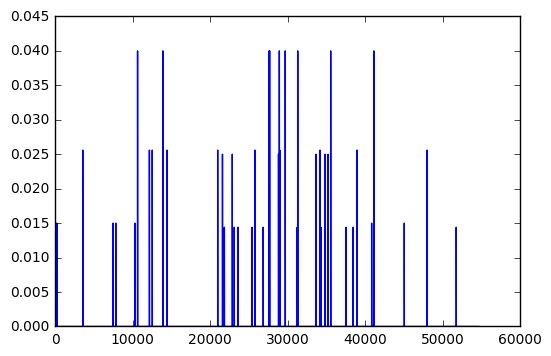

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier(n_jobs=-1, n_estimators=25)
classifier = classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)
print("score :", score)

plt.plot(classifier.feature_importances_)

## Feature selection

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# 
# # create a base classifier used to evaluate a subset of attributes
# model = LogisticRegression()
# # create the RFE model and select 3 attributes
# rfe = RFE(model, 30)
# rfe = rfe.fit(X_train, y_train)
# # summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)